Il s'agit du notebook final de notre projet qui contient le pipeline de modélisation :

- Installation de notre librairie et mise à jour des dépendances
- Chargement des données d'imagerie médicale
- Préparation des jeux de données : entrainement, validation et test
- Modélisation d'un réseau de convolution
  - Apprentissage par transfer learning
  - Optimisation par fine tuning
- Prédiction sur un jeu d'images de test
- Visualisation des résultats dont Grad-CAM

# 1. Préparation de l'environnement

In [1]:
!pip -q install git+https://github.com/corralien/yawbcc.git

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
print(f'Tensorflow: {tf.__version__}')
gpu_count = sum(1 for dev in tf.config.experimental.list_physical_devices()
                    if dev.device_type == 'GPU')
print(f'Number of GPUs: {gpu_count}')

Tensorflow: 2.10.0
Number of GPUs: 1


# 2. Chargement des données

Nous téléchargeons les images à partir d'une archive zip. Nous avons à disposition 2 jeux de données :
- [`barcelona`](https://cloud.minesparis.psl.eu/index.php/s/r9oFCMOTI5zVcd9/download) : le jeu de données original des images médicales,
- [`barcelona_remapped`](https://cloud.minesparis.psl.eu/index.php/s/MmAkMdd9wrmcgUq/download) : un jeu de données avec les tailles et les couleurs corrigées,
- [`barcelona_256_masked`](https://cloud.minesparis.psl.eu/index.php/s/S5mPzVRXmwXUiYc/download) : un jeu de données restreint issu d'un processus de segmentation.

In [1]:
import urllib.request
import pathlib
import shutil

DATASETS = {
    'barcelona': 'https://cloud.minesparis.psl.eu/index.php/s/r9oFCMOTI5zVcd9/download',
    'barcelona_remapped': 'https://cloud.minesparis.psl.eu/index.php/s/MmAkMdd9wrmcgUq/download',
    'barcelona_256_masked': 'https://cloud.minesparis.psl.eu/index.php/s/S5mPzVRXmwXUiYc/download',
}

# Change HERE
dataset = 'barcelona'  # choose one above

# Define some folders
BASE_DIR = pathlib.Path.home() / 'yawbcc_data'
BASE_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR = BASE_DIR / dataset

print(f'Base directory {BASE_DIR}')
print(f'Data directory {DATA_DIR}')

arch, _ = urllib.request.urlretrieve(DATASETS[dataset])
shutil.unpack_archive(arch, BASE_DIR, 'zip')

Base directory /home/damien/yawbcc_data
Data directory /home/damien/yawbcc_data/barcelona


Puis nous créons 3 jeux de données : `train`, `valid` et `test` :

In [1088]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Find images of dataset
data = []
for file in DATA_DIR.glob('**/*.jpg'):
    d = {'image': file.name,
         'group': file.parent.name.upper(),
         'label': file.stem.split('_')[0].upper(),
         'path': str(file)}
    data.append(d)

# Create dataframe and select columns
df = pd.DataFrame(data)
X = df['path']
y, cats = pd.factorize(df['group'])

# For converting numeric class to label
num_to_label = dict(enumerate(cats))

# Split into 3 balanced datasets 
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, stratify=y, random_state=2022)
X_train, X_valid, y_train, y_valid = \
    train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=2022)

# Remember each dataset
df.loc[X_train.index, 'dataset'] = 'train'
df.loc[X_test.index, 'dataset'] = 'test'
df.loc[X_valid.index, 'dataset'] = 'valid'

print(f'Train: {len(X_train)} records')
print(f'Valid: {len(X_valid)} records')
print(f'Test: {len(X_test)} records')

df.groupby('group').sample(n=1, random_state=2022).sort_index()

Train: 10938 records
Valid: 2735 records
Test: 3419 records


,image,group,label,path,dataset
978,MO_70803.jpg,MONOCYTE,MO,/home/damien/yawbcc_data/barcelona/monocyte/M...,train
2017,BA_418106.jpg,BASOPHIL,BA,/home/damien/yawbcc_data/barcelona/basophil/B...,train
3286,PLATELET_766529.jpg,PLATELET,PLATELET,/home/damien/yawbcc_data/barcelona/platelet/P...,test
7993,BNE_384128.jpg,NEUTROPHIL,BNE,/home/damien/yawbcc_data/barcelona/neutrophil...,train
10233,EO_487653.jpg,EOSINOPHIL,EO,/home/damien/yawbcc_data/barcelona/eosinophil...,train
11659,ERB_488753.jpg,ERYTHROBLAST,ERB,/home/damien/yawbcc_data/barcelona/erythrobla...,train
14162,LY_137344.jpg,LYMPHOCYTE,LY,/home/damien/yawbcc_data/barcelona/lymphocyte...,train
16330,MMY_342324.jpg,IG,MMY,/home/damien/yawbcc_data/barcelona/ig/MMY_342...,train


A l'instar des générateurs, nous avons créé un chargeur de données qui hérite de la classe [Sequence](https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence). Les images sont chargées et prétraitées à la demande par le modèle de convolution :

In [1089]:
from yawbcc.datasets import WBCDataSequence

NUM_CLASSES = len(np.unique(y))
INPUT_SHAPE = (256, 256, 3)
BATCH_SIZE = 32

train_ds = WBCDataSequence(X_train, y_train, image_size=INPUT_SHAPE[:2], batch_size=BATCH_SIZE)
valid_ds = WBCDataSequence(X_valid, y_valid, image_size=INPUT_SHAPE[:2], batch_size=BATCH_SIZE)
test_ds = WBCDataSequence(X_test, y_test, image_size=INPUT_SHAPE[:2], batch_size=BATCH_SIZE)

# 3. Modélisation d'un réseau de convolution

Nous chargeons un modèle applicatif issu de la page [Keras Applications](https://keras.io/api/applications/) comme départ de notre modélisation :
- [VGG16](https://keras.io/api/applications/vgg/#vgg16-function) par Damien
- [MobileNetV2](https://keras.io/api/applications/mobilenet/#mobilenetv2-function) par Anastasiya
- [ResNet50V2](https://keras.io/api/applications/resnet/#resnet50v2-function) par Jordan
- [Xception](https://keras.io/api/applications/xception/) par Jérémy

## A. Transfer learning

La première partie consiste à charger le modèle applicatif puis à l'intégrer dans notre modèle. Le modèle final sera composé ainsi :

- Une couche d'entrée au format des images, par exemple (256, 256, 3),
- Des couches de transformations (RandomFlip, RandomRotation, etc),
- Le modèle fonctionnel applicatif (VGG16, ResNet50, MobileNet, etc),
- Les couches de tête de réseau dont la dernière couche de classification.

Afin de standardiser le processus de création de nos modèles, nous utilisons la fonction [`model_factory`](https://github.com/corralien/yawbcc/blob/e87ab4c0388a330ccab94d2b9f6d6ac672428a55/yawbcc/models.py#L9) qui se charge d'assembler pour nous les différentes couches présentées ci-dessus.

In [5]:
from tensorflow.keras.layers import Flatten, Dense, Dropout, RandomFlip, RandomRotation
from tensorflow.keras.optimizers import Adam
from yawbcc.models import model_factory

top_net = [
    Dropout(0.2, seed=2022, name='dropout'),
    Flatten('channels_last', name='flatten'),
    Dense(256, activation='relu', name='fc1'),
    Dense(256, activation='relu', name='fc2'),
    Dense(NUM_CLASSES, activation='softmax', name='predictions')
]

transformers = [
#    RandomFlip(mode='horizontal', seed=2022, name='random_flip'),
#    RandomRotation(factor=(-0.2, 0.3), seed=2022, name='random_rotation')
]

app_name = 'VGG16'

model = model_factory(app_name, top_net, input_shape=INPUT_SHAPE, pooling='avg',
                      transformers=transformers, name=f'WBC-{app_name}')
model.summary()

Model: "WBC-VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 preprocess (Lambda)         (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 fc1 (Dense)                 (None, 256)               131328    
                                                                 
 fc2 (Dense)                 (None, 256)               65

Nous commençons l'entraînement sur 10 epochs :

In [6]:
TL_EPOCHS = 10

adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
tl_history = model.fit(train_ds, epochs=TL_EPOCHS, validation_data=valid_ds)
model.save(DATA_DIR / f'{model.name}_tl.hdf5')

loss, accuracy = model.evaluate(test_ds)
print(f'Loss function: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')

Epoch 1/10
342/342 [==============================] - 143s 417ms/step - loss: 0.9399 - accuracy: 0.6829 - val_loss: 0.3587 - val_accuracy: 0.8892
Epoch 2/10
342/342 [==============================] - 137s 401ms/step - loss: 0.5256 - accuracy: 0.8123 - val_loss: 0.3310 - val_accuracy: 0.8878
Epoch 3/10
342/342 [==============================] - 137s 402ms/step - loss: 0.4514 - accuracy: 0.8391 - val_loss: 0.3226 - val_accuracy: 0.8764
Epoch 4/10
342/342 [==============================] - 139s 405ms/step - loss: 0.3984 - accuracy: 0.8576 - val_loss: 0.2603 - val_accuracy: 0.9144
Epoch 5/10
342/342 [==============================] - 140s 410ms/step - loss: 0.3809 - accuracy: 0.8664 - val_loss: 0.2713 - val_accuracy: 0.9064
Epoch 6/10
342/342 [==============================] - 140s 409ms/step - loss: 0.3689 - accuracy: 0.8664 - val_loss: 0.2907 - val_accuracy: 0.8954
Epoch 7/10
342/342 [==============================] - 140s 408ms/step - loss: 0.3581 - accuracy: 0.8705 - val_loss: 0.2749 -

La première itération à partir du modèle entraîné donne un résultat satisfaisant que nous pouvons améliorer par le fine tuning.

## B. Fine tuning

Nous reprenons notre modèle initial et nous déverrouillons le modèle applicatif pour pouvoir les couches hautes de ce dernier :

In [7]:
NUM_TRAIN_LAYERS = 5
app_model = model.get_layer(app_name.lower())
app_model.trainable = True
for layer in app_model.layers[:-NUM_TRAIN_LAYERS]:
    layer.trainable = False
model.summary()

Model: "WBC-VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 preprocess (Lambda)         (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 fc1 (Dense)                 (None, 256)               131328    
                                                                 
 fc2 (Dense)                 (None, 256)               65

Nous recommençons l'entraînement en partant des poids et des biais précédents.  
En revanche, nous descendons le `learning_rate` afin de chercher plus finement les paramètres optimaux :

In [8]:
FT_EPOCHS = 10

adam = Adam(learning_rate=0.00001)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
ft_history = model.fit(train_ds, epochs=TL_EPOCHS+FT_EPOCHS, initial_epoch=TL_EPOCHS, validation_data=valid_ds)
model.save(DATA_DIR / f'{model.name}_ft.hdf5')

loss, accuracy = model.evaluate(test_ds)
print(f'Loss function: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')

Epoch 11/20
342/342 [==============================] - 154s 448ms/step - loss: 0.1539 - accuracy: 0.9459 - val_loss: 0.1202 - val_accuracy: 0.9623
Epoch 12/20
342/342 [==============================] - 157s 458ms/step - loss: 0.0893 - accuracy: 0.9698 - val_loss: 0.1194 - val_accuracy: 0.9612
Epoch 13/20
342/342 [==============================] - 155s 454ms/step - loss: 0.0542 - accuracy: 0.9816 - val_loss: 0.1164 - val_accuracy: 0.9642
Epoch 14/20
342/342 [==============================] - 154s 451ms/step - loss: 0.0420 - accuracy: 0.9852 - val_loss: 0.1079 - val_accuracy: 0.9653
Epoch 15/20
342/342 [==============================] - 156s 455ms/step - loss: 0.0325 - accuracy: 0.9883 - val_loss: 0.0958 - val_accuracy: 0.9707
Epoch 16/20
342/342 [==============================] - 155s 455ms/step - loss: 0.0233 - accuracy: 0.9928 - val_loss: 0.0959 - val_accuracy: 0.9733
Epoch 17/20
342/342 [==============================] - 156s 457ms/step - loss: 0.0188 - accuracy: 0.9944 - val_loss: 0

Le résultat obtenu est bien meilleur après l'optimisation par du fine tuning.

Nous disposons désormais de 2 modèles entraînés :

- `WBC-{app_name}_tl.hdf5` pour le modèle issu du transfer learning sur l'ensemble du jeu de données de Barcelone,
- `WBC-{app_name}_ft.hdf5` pour le modèle issu du fine tuning sur l'ensemble du jeu de données de Barcelone

## C. Affichage des résultats d'entraînement

Le tableau ci-dessous donne l'accuracy du modèle sur l'ensemble des 2 périodes d'entrainement (transfer learning et fine tuning).  
Nous voyons immédiatement le gain obtenu à partir de la deuxième partie de l'entraînement :

In [9]:
cols = ['Training Loss', 'Training Accuracy', 'Validation Loss', 'Validation Accuracy']
metrics = pd.concat([pd.DataFrame(tl_history.history),
                     pd.DataFrame(ft_history.history)],
                    ignore_index=True)
metrics.columns = cols
metrics

,Training Loss,Training Accuracy,Validation Loss,Validation Accuracy
0,0.939864,0.682940,0.358705,0.889214
1,0.525649,0.812306,0.330967,0.887751
2,0.451369,0.839093,0.322622,0.876417
3,0.398362,0.857561,0.260271,0.914442
4,0.380938,0.866429,0.271328,0.906399
5,0.368875,0.866429,0.290728,0.895430
6,0.358074,0.870452,0.274900,0.906764
7,0.334644,0.881240,0.230619,0.917367
8,0.327179,0.886999,0.257417,0.915905
9,0.316737,0.884165,0.269307,0.912980


Les mêmes données sous forme de graphique :

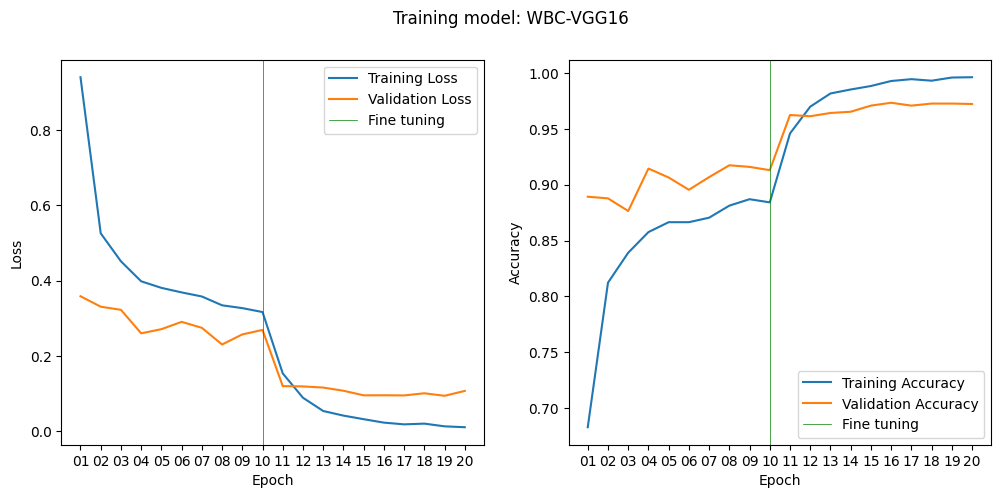

In [10]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f'Training model: {model.name}')
metrics.plot(y=cols[::2], ax=axs[0])
axs[0].set_xticks(range(len(metrics)), [f'{ep:02}' for ep in range(1, len(metrics)+1)])
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].axvline(FT_EPOCHS-1, lw=0.5, c='g', label='Fine tuning')
axs[0].legend(loc='upper right')
metrics.plot(y=cols[1::2], ax=axs[1])
axs[1].set_xticks(range(len(metrics)), [f'{ep:02}' for ep in range(1, len(metrics)+1)])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].axvline(FT_EPOCHS-1, lw=0.5, c='g', label='Fine tuning')
axs[1].legend(loc='lower right')
plt.show()

# 4. Prédictions

Nous pouvons maintenant tenter de prédire les classes de globules blancs sur le jeu de données de tests :

In [11]:
from sklearn.metrics import classification_report

preds = model.predict(test_ds)

# Create dataframe from predictions
res = pd.DataFrame(preds, columns=cats, index=X_test.index)
res['Pred'] = res.idxmax(axis=1)
res['Score'] = res.iloc[:, :NUM_CLASSES].max(axis=1)
res['Real'] = cats[y_test]
cm = pd.crosstab(res['Real'], res['Pred'])

# Display results
display(res.round(6))
display(cm)
print(classification_report(res['Real'], res['Pred']))

107/107 [==============================] - 33s 309ms/step


,MONOCYTE,BASOPHIL,PLATELET,NEUTROPHIL,EOSINOPHIL,ERYTHROBLAST,LYMPHOCYTE,IG,prediction
6807,0.000000,0.0,0.0,0.999997,0.000000,0.000000,0.000000,0.000003,NEUTROPHIL
10605,0.000000,0.0,0.0,0.000077,0.999922,0.000000,0.000000,0.000000,EOSINOPHIL
15805,0.000139,0.0,0.0,0.000006,0.000000,0.000000,0.000000,0.999854,IG
5529,0.000000,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,NEUTROPHIL
13476,0.000000,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,LYMPHOCYTE
...,...,...,...,...,...,...,...,...,...
9734,0.000000,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,EOSINOPHIL
13774,0.000003,0.0,0.0,0.000000,0.000000,0.000006,0.999991,0.000000,LYMPHOCYTE
3226,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,PLATELET
8863,0.000000,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,EOSINOPHIL


Pred,BASOPHIL,EOSINOPHIL,ERYTHROBLAST,IG,LYMPHOCYTE,MONOCYTE,NEUTROPHIL,PLATELET
Real,,,,,,,,
BASOPHIL,244,0,0,0,0,0,0,0
EOSINOPHIL,0,619,1,1,0,0,2,0
ERYTHROBLAST,2,3,299,3,1,1,1,0
IG,6,10,4,542,0,9,8,0
LYMPHOCYTE,0,0,2,1,237,3,0,0
MONOCYTE,0,6,0,3,0,275,0,0
NEUTROPHIL,0,5,0,15,0,1,645,0
PLATELET,1,0,1,2,0,0,0,466


              precision    recall  f1-score   support

    BASOPHIL       0.96      1.00      0.98       244
  EOSINOPHIL       0.96      0.99      0.98       623
ERYTHROBLAST       0.97      0.96      0.97       310
          IG       0.96      0.94      0.95       579
  LYMPHOCYTE       1.00      0.98      0.99       243
    MONOCYTE       0.95      0.97      0.96       284
  NEUTROPHIL       0.98      0.97      0.98       666
    PLATELET       1.00      0.99      1.00       470

    accuracy                           0.97      3419
   macro avg       0.97      0.97      0.97      3419
weighted avg       0.97      0.97      0.97      3419



Sous forme de heatmap :

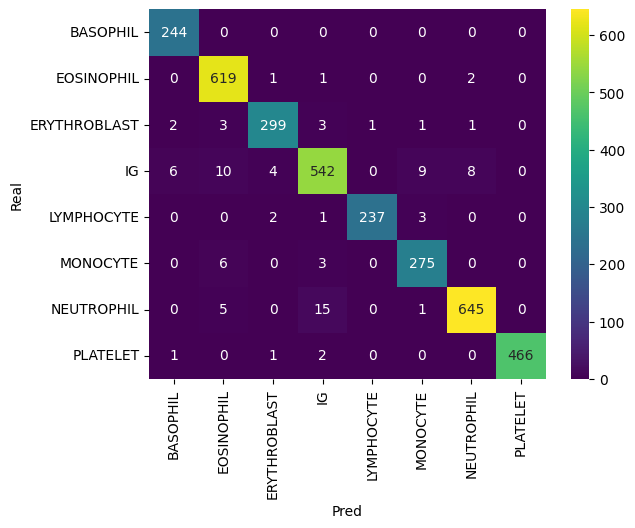

In [1166]:
import seaborn as sns

ax = sns.heatmap(cm, cmap='viridis', annot=True, fmt='01')

Visualisation des erreurs

In [ ]:
errors = (res.loc[res['Pred'] != res['Real'], ['Real', 'Pred', 'Score']]
             .groupby(['Real', 'Pred'])['Score']
             .agg(['count', 'mean']))
display(errors)

## Grad-CAM

Article: [Grad-CAM:
Visual Explanations from Deep Networks via Gradient-based Localization](https://openaccess.thecvf.com/content_ICCV_2017/papers/Selvaraju_Grad-CAM_Visual_Explanations_ICCV_2017_paper.pdf)

Nous commençons par créer 2 modèles à partir de notre modèle original :
- un premier modèle de convolution : de la couche d'entrée jusqu'à la dernière couche de convolution du modèle applicatif,
- une deuxième modèle de classification : de la couche suivant la dernière couche de convolution jusqu'à la couche de classfication.

Comme nous partons d'un modèle imbriqué (notre modèle intègre le modèle applicatif), nous allons récupérer itérativement l'ensemble des couches des modèles pour construire nos deux modèles :

In [13]:
from tensorflow.keras.models import Sequential

gradcam_layer_names = {
    'VGG16': 'block5_conv3',
    'Xception': 'block14_sepconv2_act',
    'ResNet50V2': 'conv5_block3_3_conv',
    'MobileNetV2': 'Conv_1_bn',
}

# Application model
app_model = model.get_layer(app_name.lower())

# Find application model index from our model
idx1 = [layer.name for layer in model.layers].index(app_model.name)

# Find last convolution layer index from app model
idx2 = [layer.name for layer in app_model.layers].index(gradcam_layer_names[app_name])

# Get all layers before last convolution layer (included)
conv_layers = [layer for layer in model.layers[:idx1]] \
              + [layer for layer in app_model.layers[1:idx2+1]]

# Get all layers after last convolution layer (excluded)
clf_layers = [tf.keras.Input(app_model.layers[idx2].output.shape[1:])] \
             + [layer for layer in app_model.layers[idx2+1:]] \
             + [layer for layer in model.layers[idx1+1:]]

# Build 2 models: one for convolution, other for classification
conv_model = tf.keras.models.Sequential(conv_layers, f'{model.name}-conv')
clf_model = tf.keras.models.Sequential(clf_layers, f'{model.name}-clf')

### Modèle de convolution

In [14]:
conv_model.summary()

Model: "WBC-VGG16-conv"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Lambda)         (None, 256, 256, 3)       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)    

### Modèle de classification

In [15]:
clf_model.summary()

Model: "WBC-VGG16-clf"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block5_pool (MaxPooling2D)  (None, 8, 8, 512)         0         
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 fc1 (Dense)                 (None, 256)               131328    
                                                                 
 fc2 (Dense)                 (None, 256)               65792     
                                                     

### Visualisation
Nous créons un jeu de démonstration pour l'affichage du Grad-CAM :

In [1193]:
idx = df.loc[df['dataset'] == 'test'].groupby('group').sample(n=1, random_state=2022).index
demo_ds = WBCDataSequence(X[idx], y[idx], image_size=INPUT_SHAPE[:2], batch_size=len(idx))
df.loc[idx]

,image,group,label,path,dataset
2175,BA_472351.jpg,BASOPHIL,BA,/home/damien/yawbcc_data/barcelona/basophil/B...,test
10819,EO_430628.jpg,EOSINOPHIL,EO,/home/damien/yawbcc_data/barcelona/eosinophil...,test
12324,ERB_579519.jpg,ERYTHROBLAST,ERB,/home/damien/yawbcc_data/barcelona/erythrobla...,test
15813,MY_384910.jpg,IG,MY,/home/damien/yawbcc_data/barcelona/ig/MY_3849...,test
13695,LY_544639.jpg,LYMPHOCYTE,LY,/home/damien/yawbcc_data/barcelona/lymphocyte...,test
655,MO_83718.jpg,MONOCYTE,MO,/home/damien/yawbcc_data/barcelona/monocyte/M...,test
8172,BNE_571324.jpg,NEUTROPHIL,BNE,/home/damien/yawbcc_data/barcelona/neutrophil...,test
3831,PLATELET_479788.jpg,PLATELET,PLATELET,/home/damien/yawbcc_data/barcelona/platelet/P...,test


In [1256]:
def compute_grad_cam_heatmaps(images, conv_model, clf_model):
    with tf.device('/CPU:0'), tf.GradientTape() as tape:
        # Get the output of convolution model (x)
        sources = conv_model(images)

        # Get the prediction from the output of convolution model (y)
        preds = clf_model(sources)
        indexes = tf.argmax(preds, axis=1)
        targets = tf.gather_nd(preds, tf.reshape(indexes, (-1, 1)), batch_dims=1)

    # Compute gradients
    grads = tape.gradient(targets, sources)

    # Compute the average of each filter (GlobalAveragePooling2D) (u, v, Z) -> Z
    pooled_grads = tf.reduce_mean(grads, axis=(1, 2))

    # Create heatmaps
    heatmaps = tf.keras.backend.batch_dot(sources, pooled_grads)

    # Normalize heatmaps between 0 and 1
    original_shape = heatmaps.shape
    flatten_shape = heatmaps.shape[0], np.multiply(*heatmaps.shape[1:])
    m1 = tf.reshape(tf.maximum(heatmaps, 0), flatten_shape)
    m2 = tf.math.reduce_max(heatmaps, axis=(1, 2))
    heatmaps = tf.reshape(m1 / m2[..., None], original_shape)
    heatmaps = tf.floor(255 * heatmaps).numpy()
    
    return heatmaps

images, targets = demo_ds[0]  # the only batch of NUM_CLASSES images
heatmaps = compute_grad_cam_heatmaps(images, conv_model, clf_model)

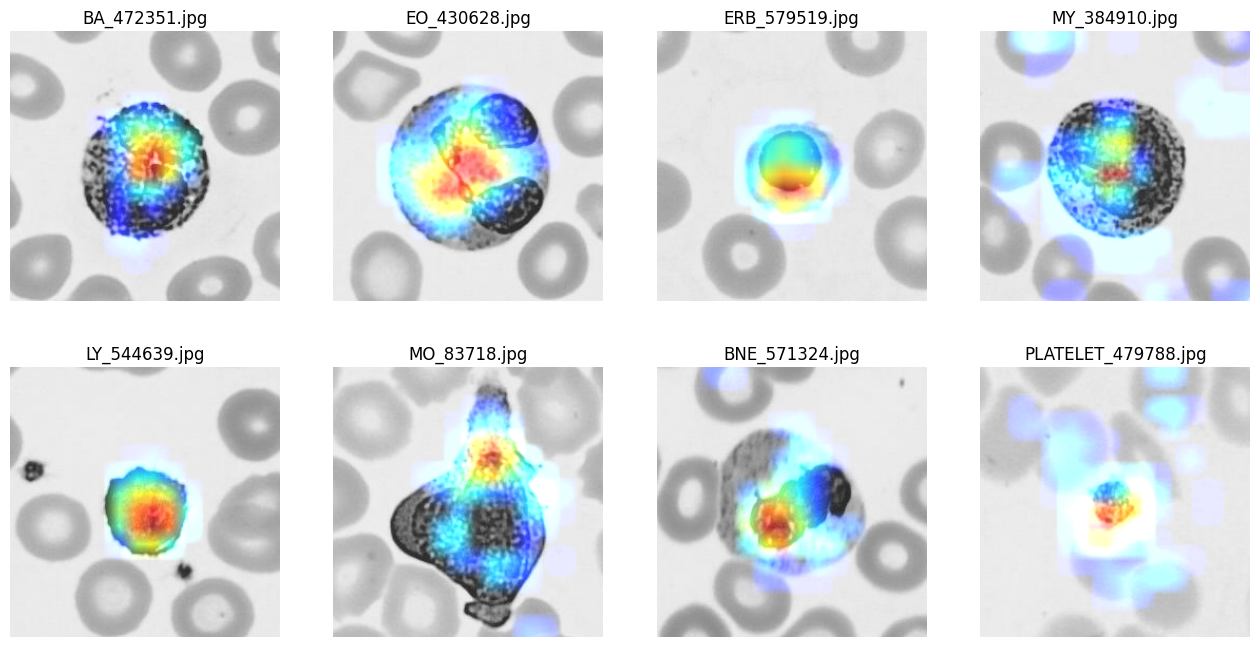

In [1257]:
import cv2

cmap = plt.cm.get_cmap('jet')
colors = np.uint8(255 * cmap(np.arange(256))[:, :3])
colors[:30] = 0  # threshold low attention colors

images = np.uint8(images)
heatmaps = np.uint8(heatmaps)

fig, axs = plt.subplots(2, 4, figsize=(16, 8))
for rec, ax, image, heatmap in zip(df.loc[idx].itertuples(), axs.flat, images, heatmaps):

    # Resize and color heatmap
    heatmap = cv2.resize(colors[heatmap], image.shape[:2])

    # Convert image to gray (1 channel) then recolor (3 channels)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)

    # Blend image and heatmap with alpha channel
    final = cv2.addWeighted(image, 1, heatmap, 0.8, 0)

    # Plot figure
    ax.set_title(rec.image)
    ax.imshow(final)
    ax.axis('off')